# <i>Dscam</i> Manuscript (Figure 2)
This notebook details to code for visualizations produced for Figure 2 of the <i>Dscam</i> RNAi manuscript.

## Environment setup

In [1]:
# Set working directory
# setwd("/Users/alexplocik/Google Drive/UConn/Lab Notebook/Dscam 4.2 EMAP/miSeq data analysis/")

# Install required packages
require(gplots)
require(ggplot2)
require(grid)
require(RColorBrewer)
require(repr)
require(plyr)
require(gplots)
require(Vennerable)
require(reshape2)
source("packages/heatmap.3.R")

# Set figure dimensions for notebook
options(repr.plot.width = 6, repr.plot.height = 3)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: ggplot2
Loading required package: grid
Loading required package: RColorBrewer
Loading required package: repr
Loading required package: plyr
Loading required package: Vennerable
Loading required package: graph

Attaching package: ‘graph’

The following object is masked from ‘package:plyr’:

    join

Loading required package: RBGL
Loading required package: lattice
Loading required package: reshape

Attaching package: ‘reshape’

The following objects are masked from ‘package:plyr’:

    rename, round_any

Loading required package: gtools
Loading required package: xtable
Loading required package: reshape2

Attaching package: ‘reshape2’

The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast



## Custom functions

In [2]:
# A ggplot theme good for small manuscript sized images
theme_bw_small <- function (base_size = 10, base_family = "") 
{
  theme_grey(base_size = base_size, base_family = base_family) %+replace% 
    theme(axis.text = element_text(size = rel(0.8)),
          axis.text.x = element_text(angle = 90, vjust = 0.5),
          axis.ticks = element_line(colour = "black"), 
          legend.key = element_rect(colour = "grey80"),
          panel.background = element_rect(fill = "white", colour = NA),
          panel.border = element_rect(fill = NA, colour = "grey50"), 
          panel.grid.major = element_line(colour = "grey90", size = 0.2), 
          panel.grid.minor = element_line(colour = "grey98", size = 0.5), 
          strip.background = element_rect(fill = "white", colour = "white", size = 0.2)) 
} # theme_bw_small()

plotting.factor.levels <- function(data){
  data$library <- factor(data$library, levels = levels(factor(data$library))[c(3:8, 1:2)], labels = gsub(" \\(", "\n(", levels(factor(data$library)))[c(3:8, 1:2)])
  data$exon <- factor(data$exon, levels = levels(factor(data$exon))[c(3:length(levels(factor(data$exon))), 1:2)])
  data
} # plotting.factor.levels()
move.rownames <- function(df, row = 1){rownames(df) <- df[, row];  df <- df[, -row]}


## Read data from file

In [3]:
all <- read.csv("data/Combined RNAi experiment data.csv", row.names = 1); all <- plotting.factor.levels(all)
all.filter <- subset(all, PSI.median > 0.1 & exon != "17.skip" & ((exon_cluster != 17 & cor >= 0.8) | exon_cluster == 17))

## Subset significant z-scores and calculate mean z-scores

In [4]:
# replace FBgn names with gene names
all.filter$protein <- sub("^FBgn[0-9]*\\.\\.([A-Za-z0-9.]*)\\.$", "\\1", all.filter$RNAi)
# transform z-score data into wide format by replicate
all.filter.z.wide <- dcast(all.filter, RNAi + protein + exon + exon_cluster ~ replicate, value.var = "z.score")
# subset significant z-scores in both replicates
sig.z.wide <- subset(all.filter.z.wide, (Rep4 > 1.96 & Rep5 > 1.96) | (Rep4 < -1.96 & Rep5 < -1.96))

In [5]:
# calculate the mean z-score
all.average.z <- ddply(all.filter, .(RNAi, protein, exon, exon_cluster), summarize, n = length(z.score), average.z = mean(z.score))
all.average.z.wide <- dcast(all.average.z, protein ~ exon, value.var = "average.z")

In [6]:
# subset the mean z-scores with significant z-scores in both replicates
sig.average.z.wide <- merge(as.matrix(unique(sig.z.wide$protein), ncol = 1), all.average.z.wide, by.x = 1, by.y = 1, all.x = T)
sig.average.z.wide <- move.rownames(sig.average.z.wide)
sig.z.wide$average.z <- apply(cbind(sig.z.wide$Rep4, sig.z.wide$Rep5), 1, mean)

## Write data to file

In [7]:
# write significant mean z-scores to file
write.csv(sig.average.z.wide, "data/Significant z-score matrix.csv")
write.csv(sig.z.wide, "data/Significant z-scores.csv")

In [9]:
# read data from file
sig.matrix <- read.csv("data/Significant z-score matrix.csv", row.names = 1)
sig.hits <- read.csv("data/Significant z-scores.csv")

# Figure 2A.
The following figure illustrates RNAi depletion affects on variant exon PSI. The data was first filtered to remove exons with < 0.1 PSI and experiments with a Spearman correlation coefficient of < 0.8. Points indicate outliers.

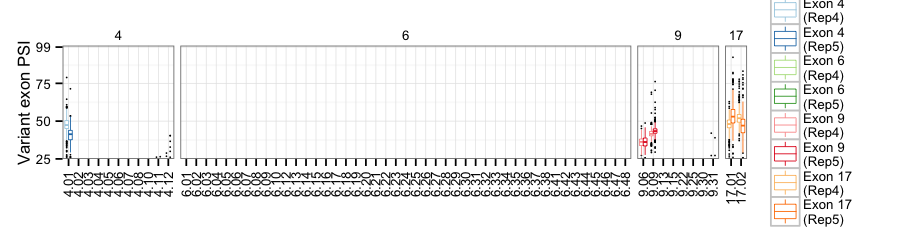

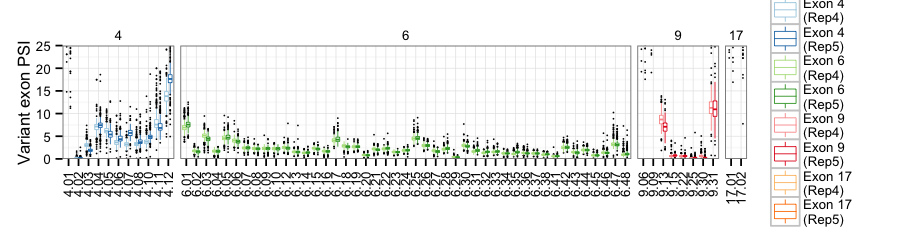

In [11]:
w = 7.5; h = 2; options(repr.plot.width = w, repr.plot.height = h)

data <- all.filter
p <- ggplot(subset(data, splice_event == "inclusion"), aes(x = exon, y = PSI,  color = library)) +
  geom_boxplot(outlier.size = 0.5, size = 0.25) +
  facet_grid(. ~ exon_cluster, space = "free", scale = "free") +
  scale_color_manual(values = brewer.pal(8, "Paired")) +
  theme_bw_small() +
  ylab("Variant exon PSI") +
  xlab("")
p + scale_y_continuous(breaks = c(25, 50, 75, 99)) + coord_cartesian(ylim=c(25, 100))
ggsave("Figures/Figure 2A top. Exon variant inclusion PSI boxplots and points (filtered).pdf", height = h, width = w)
p + scale_y_continuous(breaks = c(seq(0, 25, 5))) + coord_cartesian(ylim=c(0, 25))
ggsave("Figures/Figure 2A bottom. Exon variant inclusion PSI boxplots and points (filtered).pdf", height = h, width = w)

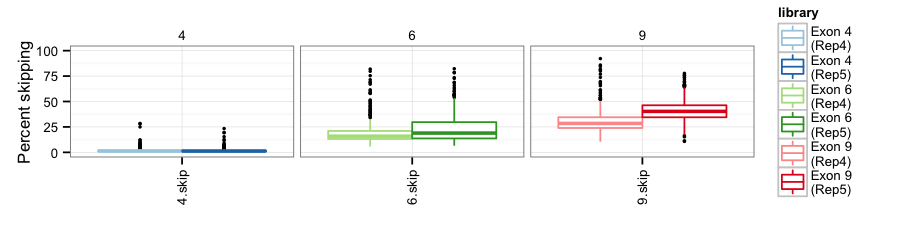

In [12]:
ggplot(subset(data, splice_event == "skipping"), aes(x = exon, y =  PSI,  color = library)) +
  geom_boxplot(outlier.size = 1) + facet_grid(. ~ exon_cluster, space = "free", scale = "free") +
  scale_color_manual(values = brewer.pal(8, "Paired")) +
  theme_bw_small() +
  scale_y_continuous(breaks = c(seq(0, 100, 25)), limits = c(0, 100)) +
  ylab("Percent skipping") +
  xlab("")
ggsave("Figures/Figure 2A. Exon variant skipping PSI boxplots and points (filtered).pdf", height = 4, width = 2.5)

# Figure 2B.

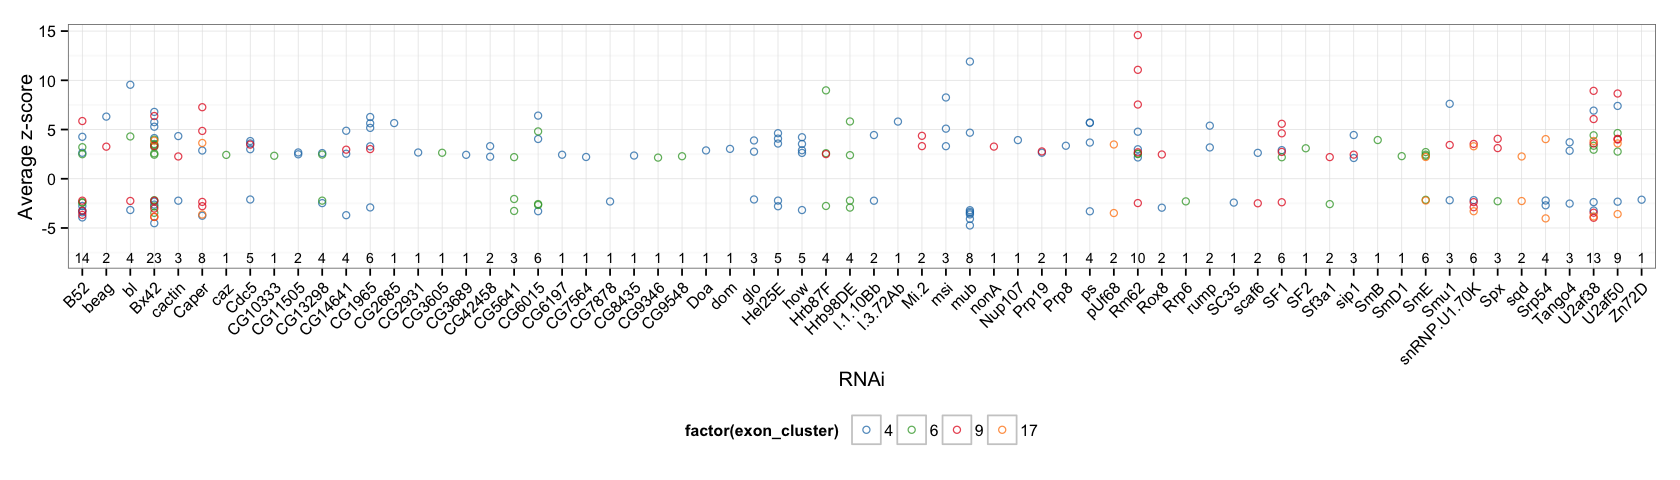

In [14]:
w = 14; h = 4; options(repr.plot.width = w, repr.plot.height = h)

sig.hits.n <- ddply(sig.hits, "protein", summarize, n = length(protein))

ggplot(sig.hits, aes(x = protein, y = average.z, color = factor(exon_cluster))) +
  geom_point(shape = 1, alpha = 0.75) + 
  geom_text(data = sig.hits.n, aes(x = protein, y = -8, label = n), color = "black", size = 3) +
  scale_color_manual(values = brewer.pal(8, "Paired")[c(2, 4, 6, 8)]) +
  xlab("RNAi") + 
  ylab("Average z-score") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom")
ggsave("Figures/Figure 2B. Significant hits by exon cluster (horizontal).pdf", width = w, height = h)

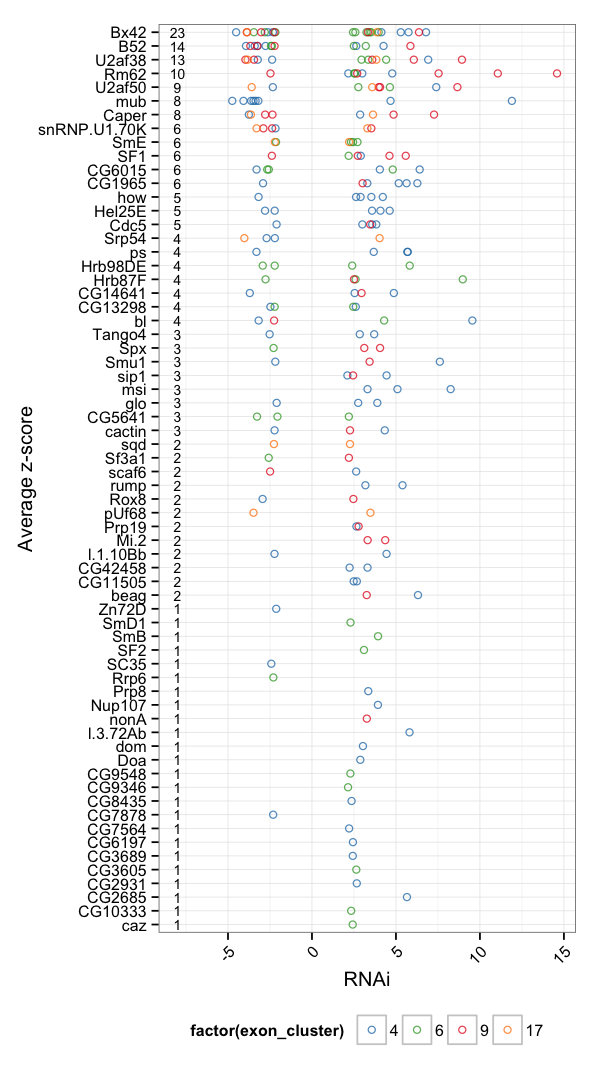

In [15]:
w = 5; h = 9; options(repr.plot.width = w, repr.plot.height = h)

sig.hits.n <- ddply(sig.hits, "protein", summarize, n = length(protein))
sig.hits$protein <- factor(sig.hits$protein, levels = sig.hits.n$protein[order(sig.hits.n$n)])

ggplot(sig.hits, aes(y = protein, x = average.z, color = factor(exon_cluster))) +
geom_point(shape = 1, alpha = 0.75) + 
  geom_text(data = sig.hits.n, aes(y = protein, x = -8, label = n), color = "black", size = 3) +
  scale_color_manual(values = brewer.pal(8, "Paired")[c(2, 4, 6, 8)]) +
  xlab("RNAi") + 
  ylab("Average z-score") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom")
ggsave("Figures/Figure 2B. Significant hits by exon cluster (vertical).pdf", width = w, height = h)

# Figure 2B. Z-score heatmap

In [16]:
colnames(sig.matrix) <- as.character(gsub("X", "", colnames(sig.matrix)))
filter <- unique(c(which(apply(sig.matrix, 2, max, na.rm = T) > 1.96), which(apply(sig.matrix, 2, min, na.rm = T) < -1.96)))
filter <- filter[order(filter)]
sig.matrix.filter <- as.matrix(sig.matrix[, filter])
#sig.matrix.filter <- sig.matrix.filter[, -dim(sig.matrix.filter)[2]]

pal <- brewer.pal(n = 8, "Paired")
exon_col <- colnames(sig.matrix.filter)
exon_col <- gsub("^4.*", pal[2], exon_col)
exon_col <- gsub("^6.*", pal[4], exon_col)
exon_col <- gsub("^9.*", pal[6], exon_col)
exon_col <- gsub("^17.*", pal[8], exon_col)

pdf 
  2

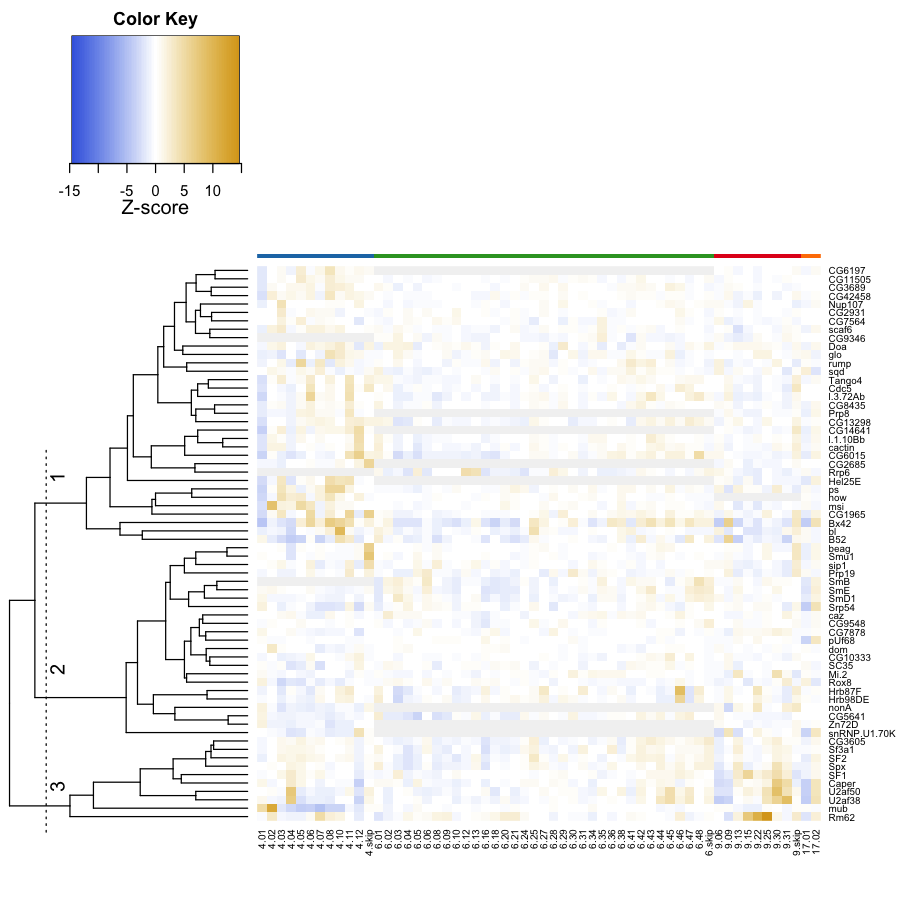

In [17]:
w = 7.5; h = 7.5; options(repr.plot.width = w, repr.plot.height = h)
colnames(sig.matrix) <- as.character(gsub("X", "", colnames(sig.matrix)))
par(xpd = T)
pdf("Figures/Figure 2B. Z-score heatmap.pdf", width = w, height = h)

heatmap.3(sig.matrix.filter, 
          Colv = F, 
          na.color = "gray95", 
          dendrogram = "row", 
          col = colorpanel(n = 100, low = "royalblue", mid = "white", high = "goldenrod"), 
          #trace = "row", 
          tracecol = NULL,
          linecol = "gray80",
          KeyValueName = "Z-score",
          ColSideColors = as.matrix(exon_col),
          lhei = c(2,5),
          lwid = c(2,5),
          side.height.fraction = 0.20
         )
mtext(side = 2, line = 1.5, text = "1", at = 0.44)
mtext(side = 2, line = 1.5, text = "2", at = 0.15)
mtext(side = 2, line = 1.5, text = "3", at = -0.025)
segments(x0 = -0.08, x1 = -0.08, y0 = 0.48, y1 = -0.1, lty = 3)
dev.off()
heatmap.3(sig.matrix.filter, 
          Colv = F, 
          na.color = "gray95", 
          dendrogram = "row", 
          col = colorpanel(n = 100, low = "royalblue", mid = "white", high = "goldenrod"), 
          #trace = "row", 
          tracecol = NULL,
          linecol = "gray80",
          KeyValueName = "Z-score",
          ColSideColors = as.matrix(exon_col),
          lhei = c(2,5),
          lwid = c(2,5),
          side.height.fraction = 0.20
         )
mtext(side = 2, line = 1.5, text = "1", at = 0.44)
mtext(side = 2, line = 1.5, text = "2", at = 0.15)
mtext(side = 2, line = 1.5, text = "3", at = -0.025)
segments(x0 = -0.08, x1 = -0.08, y0 = 0.48, y1 = -0.1, lty = 3)

Heirachical clustering groups the z-score profiles by exon 4 splicing, which distinguishes depletions that (1) generally reduce 4.1 splicing from those that generally increase 4.1 splicing or (2 and 3) have little effect). Between the latter groups (2 and 3), RNAi depletions are distinguished further by their effects on exon 9.

#### Notable clusters:

U2af50, U2af38, --- 3'ss --- 
4.04⬆, 4.12⬇;
6.44⬆, 6.45⬆, 6.47⬆; 
9.06⬇, 9.09⬇, 9.25⬆, 9.30⬆, 9.31⬆

U2af50, U2af38, SF1, Caper ---
4.04⬆, 4.12⬇;
9.06⬇, 9.09⬇, 9.25⬆, 9.30⬆, 9.31⬆

Bx42, B52 --- 

Tango4, Cdc5 --- Prp19 complex ---

#### Unique profiles:
mub --- KH domain protein; poly(C) binding --- 4.01⬆, 4.02⬆, 4.03 - 4.10⬇; 4.12⬇




# Figure 2.
A decent number of Illustrator changes later...

<img src="images/Figure%202.png"/>